[joyofdata.de](http://blog.joyofdata.de/) - [@joyofdata](https://twitter.com/joyofdata) - Raffael Vogler

#Trying to get caffe to learn a linear separation

In [57]:
import platform
print "OS: ", platform.platform()
print "Python: ", sys.version
print "LMDB: ", lmdb.version()

OS:  Linux-3.13.0-49-generic-x86_64-with-Ubuntu-14.04-trusty
Python:  2.7.6 (default, Mar 22 2014, 22:59:56) 
[GCC 4.8.2]
LMDB:  (0, 9, 14)


---

In [1]:
import subprocess

sys.path.append("/home/ubuntu/caffe/python/")
import caffe
import lmdb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Create Data

In [8]:
def create_toy_data_set(csv_name, N, do_plot=False):
    df = pd.DataFrame(index=range(0,N), columns=["label","x","y"])
    df.x = np.random.uniform(-1,1,N)
    df.y = np.random.uniform(-1,1,N)
    df.label = 0
    df.label = np.where(df.y > df.x, 1, df.label)
    #df.label = np.where((df.y < 0) & (df.x**2 < abs(df.y)), 2, df.label)
    df.to_csv(csv_name, index=False)
    if do_plot:
        plt.scatter(df.x,df.y,c=[["red","green","blue"][i] for i in df.label], s=100)
        plt.show()
    

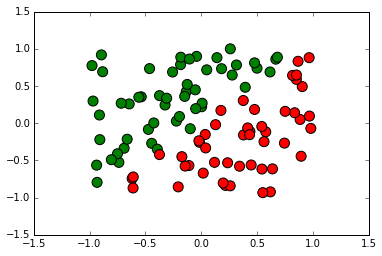

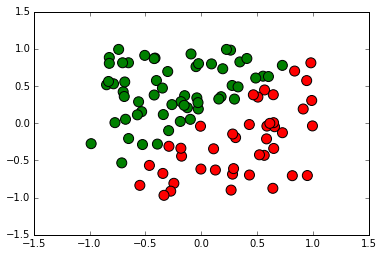

In [11]:
create_toy_data_set("train_data.csv", N=100, do_plot=True)
create_toy_data_set("test_data.csv", N=100, do_plot=True)

#Load Data

In [12]:
def load_csv_into_lmdb(csv_name, lmdb_name):
    df = pd.read_csv(csv_name)
    y = df.ix[:,0].as_matrix()
    x = df.ix[:,1:].as_matrix()
    x = x[:,:,None,None]
    env = lmdb.open(lmdb_name)
    
    for i in range(x.shape[0]):
        datum = caffe.proto.caffe_pb2.Datum()
        datum.channels = 2
        datum.height = 1
        datum.width = 1
        #datum.data = x[i].tostring()
        datum.float_data.extend(x[i].flat)
        
        datum.label = int(y[i])
        str_id = '{:08}'.format(i)
        with env.begin(write=True) as txn:
            txn.put(str_id, datum.SerializeToString())

In [14]:
load_csv_into_lmdb("/home/ubuntu/data/train_data.csv", "/home/ubuntu/data/train_data_lmdb/")
load_csv_into_lmdb("/home/ubuntu/data/test_data.csv", "/home/ubuntu/data/test_data_lmdb/")

#Train Model

In [26]:
proc = subprocess.Popen(["/home/ubuntu/caffe/build/tools/caffe","train","--solver=config.prototxt"], stderr=subprocess.PIPE)
res = proc.communicate()[1]

In [27]:
print res

libdc1394 error: Failed to initialize libdc1394
I0506 09:45:08.671519 13961 caffe.cpp:113] Use GPU with device ID 0
I0506 09:45:08.811549 13961 caffe.cpp:121] Starting Optimization
I0506 09:45:08.811663 13961 solver.cpp:32] Initializing solver from parameters: 
test_iter: 100
test_interval: 500
base_lr: 0.01
display: 1000
max_iter: 10000
lr_policy: "inv"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
solver_mode: GPU
net: "model.prototxt"
I0506 09:45:08.811700 13961 solver.cpp:70] Creating training net from net file: model.prototxt
I0506 09:45:08.811955 13961 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer simple
I0506 09:45:08.811977 13961 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0506 09:45:08.812027 13961 net.cpp:42] Initializing net from parameters: 
name: "SimpleNet"
state {
  phase: TRAIN
}
layer {
  name: "simple"
  type: "Data"
  top: "data"
  top: "label"
  i

#Test Model

Predictions seem to be random - even though according to output of `caffe train` the model's accuracy went from 19% over 98% to 100%.

In [28]:
net = caffe.Classifier("model_prod.prototxt","./_iter_10001.caffemodel")

In [62]:
x = np.array([[[[0.5]],[[-0.5]]]], dtype=float32)
res = net.predict(x, oversample=False)
res

array([[ 0.48981464,  0.5101853 ]], dtype=float32)

In [60]:
x = np.array([[[[-0.5]],[[0.5]]]], dtype=float32)
res = net.predict(x, oversample=False)
res

array([[ 0.48981464,  0.5101853 ]], dtype=float32)

In [43]:
N=100
df = pd.DataFrame(index=range(0,N), columns=["label","x","y","T","l0"])
df.x = np.random.uniform(-1,1,N)
df.y = np.random.uniform(-1,1,N)
for i in range(df.shape[0]):
    x = np.array([[[[df.ix[i,"x"]]],[[df.ix[i,"y"]]]]])
    res = net.predict(x, oversample=False)
    df.ix[i,"label"] = np.argmax(res[0])
    df.ix[i,"l0"] = res[0][0]

df.T = df.y > df.x

In [45]:
df

,label,x,y,T,l0
0,0,0.725125,0.600004,False,0.6641417
1,1,-0.140740,0.049169,True,0.4428082
2,1,-0.172385,0.064281,True,0.4344049
3,0,-0.204514,0.773260,True,0.6651275
4,0,0.211900,0.718087,True,0.6646569
5,0,-0.059060,0.428838,True,0.6653866
6,1,-0.590009,-0.231401,True,0.4622667
7,0,0.359439,0.510201,True,0.6647355
8,1,-0.681555,0.135049,True,0.4294711
9,1,-0.220682,-0.318323,False,0.4285833
